In [242]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets

In [243]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise

In [244]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [245]:
#Dimensões do modelo:
n = 4 #Variáveis de estado
r = 1 #Entradas de controle
l = 1 #Entradas de distúrbio
m = 3 #Saídas

In [246]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.0 #Altura das ondas [m]
Cg = 500.0 #Momento de restituição do giroscópio [N.m]
Bg = 2500.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

Representação em Espaço de Estados do Modelo Linearizado:

In [247]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C:
C = sp.Matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

#Matriz D:
D = sp.Matrix([[0],[0],[0]])


In [248]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
Cn = sp.lambdify((),C)
En = sp.lambdify((),E)

In [249]:
E

Matrix([
[               0],
[               0],
[12.3909097110891],
[               0]])

In [250]:
#Espaço de Estados com Ω = 8000 rpm:
mod_boat1 = ct.ss(An(8000*np.pi/30),B,C,D)
mod_boat1


StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02]]), array([[0.        ],
       [0.        ],
       [0.        ],
       [0.38083148]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

Agora, com o modelo SLIT estabelecido, vamos analisar a controlabilidade e a observabilidade do sistema:

In [251]:
ct.ctrb(An(8000*np.pi/30),B)

array([[ 0.00000000e+00,  0.00000000e+00, -1.84774660e-01,
         1.75922668e+02],
       [ 0.00000000e+00,  3.80831482e-01, -3.62581544e+02,
         3.44789483e+05],
       [ 0.00000000e+00, -1.84774660e-01,  1.75922668e+02,
        -1.67287766e+05],
       [ 3.80831482e-01, -3.62581544e+02,  3.44789483e+05,
        -3.27870003e+08]])

In [252]:
np.linalg.matrix_rank(ct.ctrb(An(8000*np.pi/30),B))

4

In [253]:
ct.obsv(An(8000*np.pi/30),C)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02],
       [-2.30797515e+04,  1.81290772e+05, -1.77340254e+06,
         9.05359718e+05],
       [ 1.77604687e-01,  9.23873302e+01, -9.16118223e+02,
         4.61943606e+02],
       [-2.30797515e+04,  1.81290772e+05, -1.77340254e+06,
         9.05359718e+05],
       [ 2.19740708e+07, -1.72394742e+08,  1.68635773e+09,
      

In [254]:
np.linalg.matrix_rank(ct.obsv(An(8000*np.pi/30),C))

4

Síntese por alocação de Polos:

In [255]:
#Polos da Matriz A original:
np.linalg.eig(An(8000*np.pi/30))

(array([-9.50928098e+02+0.j       , -4.80871936e-01+3.4611418j,
        -4.80871936e-01-3.4611418j, -2.03196565e-01+0.j       ]),
 array([[-5.36555323e-07+0.j        , -2.37020339e-02-0.12225177j,
         -2.37020339e-02+0.12225177j,  7.77285344e-03+0.j        ],
        [-1.05160350e-03+0.j        , -3.37610485e-02-0.24299978j,
         -3.37610485e-02+0.24299978j,  9.79942810e-01+0.j        ],
        [ 5.10225533e-04+0.j        ,  4.34528353e-01-0.02324866j,
          4.34528353e-01+0.02324866j, -1.57941712e-03+0.j        ],
        [ 9.99999317e-01+0.j        ,  8.57291448e-01+0.j        ,
          8.57291448e-01-0.j        , -1.99121013e-01+0.j        ]]))

In [256]:
#Polinômio caracterísco da Matriz A:
p = A.charpoly()
p

PurePoly(1.0*lambda**4 + 952.093038639246*lambda**3 + (0.00128765730763755*Ω**2 + 216.453238766947)*lambda**2 + 11799.8505912531*lambda + 2359.42425472976, lambda, domain='RR[Ω]')

In [257]:
a = p.all_coeffs()
a

[1.00000000000000,
 952.093038639246,
 0.00128765730763755*Ω**2 + 216.453238766947,
 11799.8505912531,
 2359.42425472976]

In [258]:
#Matriz Q:
Q = sp.Matrix([[B, A*B, A*A*B, A*A*A*B]])
Q

Matrix([
[                0,                       0,                      -0.000220558504262905*Ω,                                                                        0.209992216521396*Ω],
[                0,       0.380831482069184,                            -362.581544337529,                                               345133.650943619 - 0.000490380440864823*Ω**2],
[                0, -0.000220558504262905*Ω,                          0.209992216521396*Ω, -0.000220558504262905*Ω*(-0.00128765730763755*Ω**2 - 12.3907042628334) - 199.88711979106*Ω],
[0.380831482069184,       -362.581544337529, 345133.650943619 - 0.000490380440864823*Ω**2,                                                   0.93376857921297*Ω**2 - 328525358.268567]])

In [259]:
#Matriz Toeplitz W:
W = sp.Matrix([[1, a[1],a[2],a[3]],[0,1,a[1],a[2]],[0,0,1,a[1]],[0,0,0,1]])
W

Matrix([
[1, 952.093038639246, 0.00128765730763755*Ω**2 + 216.453238766947,                            11799.8505912531],
[0,                1,                            952.093038639246, 0.00128765730763755*Ω**2 + 216.453238766947],
[0,                0,                                           1,                            952.093038639246],
[0,                0,                                           0,                                           1]])

In [319]:
# Polos desejados para alocação em MF
#Pretende-se manter R
λ, ζ, ω_n, r, R = sp.symbols('λ ζ ω_n r R')
p_ = sp.PurePoly((λ + r) * (λ + R) * ((λ + ζ*ω_n)**2 + ω_n**2 * (1 - ζ**2)), λ)
a_ = p_.all_coeffs()
a_

[1,
 R + r + 2*ζ*ω_n,
 R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n + ω_n**2,
 2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2,
 R*r*ω_n**2]

In [261]:
k = ((Q*W).inv()).T * (sp.Matrix(a_[1:]) - sp.Matrix(a[1:]))
kn = sp.lambdify((Omega, R, ζ, ω_n, r), k)
k

Matrix([
[                                                         (1.52897933540946e-15*Ω + 56179.6959603744/Ω)*(R + r + 2*ζ*ω_n - 952.093038639246) + 5.24474320422005*(R*r*ω_n**2 - 2359.42425472976)/Ω - 4533.9444214221*(2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2 - 11799.8505912531)/Ω + 1.13502090084848e-9*(R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n - 0.00128765730763755*Ω**2 + ω_n**2 - 216.453238766947)/Ω],
[-4.676585101913e-14*R*r*ζ*ω_n + 0.211916105800409*R*r*ω_n**2 + 2.28073753801061e-11*R*r + 4.56147507602121e-11*R*ζ*ω_n - 2.3382925509565e-14*R*ω_n**2 + 4.56147507602121e-11*r*ζ*ω_n - 2.3382925509565e-14*r*ω_n**2 - 2.93680835762263e-14*Ω**2 + 2.28073753801061e-11*ω_n**2 + (6.17790679148141e-17*Ω**2 - 3.3167588621118e-8)*(R + r + 2*ζ*ω_n - 952.093038639246) - 499.999999998023],
[                                                       (1.06671987432445e-13*Ω + 64.9870822336934/Ω)*(R + r + 2*ζ*ω_n - 952.093038639246) + 365.908922514729*(R*r*ω_n**2 - 2359.42425472976)/Ω - 4.78882314435891e-11*(2*R*r*ζ*ω_n + R

In [326]:
# Polos desejados para alocação em MF com a função control.place():
kT = ct.place(An(8000*np.pi/30), Bn(), [-1.0+2.5j, -1.0-2.5j, -np.sqrt(1.0**2 + 2.5**2), -950.0])
kT

array([[-9.31638930e+02,  3.43001837e+03, -1.10627261e+04,
         6.82596867e+00]])

Análise do sistema em malha fechada:

In [327]:
#Matriz de Estados em MF Simbólica:
A_c = A - B*k.T
A_cn = sp.lambdify((Omega, R, ζ, ω_n, r), A_c)
A_c


Matrix([
[                                                                                                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                                                                                                                                                               0,                                                                                                                                                                                                                                                        

In [328]:
#Matriz de Estados em MF a partir do ct.place() para 8000 rpm:

A_c1 = An(8000*np.pi/30) - B*kT
A_cn1 = An(8000*np.pi/30) - Bn()*kT
A_c1

Matrix([
[                0,                 0,                 1.0,                  0],
[                0,                 0,                   0,                1.0],
[-12.3909097110891,                 0, -0.0143334662850031, -0.485187462559072],
[ 354.797434284643, -1496.67471856184,    6075.67012527663,  -954.678248937282]])

In [322]:
np.linalg.eig(A_cn1)

(array([-9.50000000e+02+0.j , -5.00000000e-01+2.5j, -5.00000000e-01-2.5j,
        -2.54950976e+00+0.j ]),
 array([[ 5.37604199e-07+0.j        , -6.05978552e-02-0.02339117j,
         -6.05978552e-02+0.02339117j,  2.39051240e-02+0.j        ],
        [ 1.05263086e-03+0.j        , -7.04693296e-02-0.35234665j,
         -7.04693296e-02+0.35234665j,  3.64365035e-01+0.j        ],
        [-5.10723989e-04+0.j        ,  8.87768438e-02-0.13979905j,
          8.87768438e-02+0.13979905j, -6.09463468e-02+0.j        ],
        [-9.99999316e-01+0.j        ,  9.16101284e-01+0.j        ,
          9.16101284e-01-0.j        , -9.28952211e-01+0.j        ]]))

In [266]:
(A_c1).charpoly()

PurePoly(1.0*lambda**4 + 954.692582403567*lambda**3 + 4470.58844819603*lambda**2 + 12022.9277892036*lambda + 18545.1613045695, lambda, domain='RR')

Simulação do Sistema Controlado:

array([[list([<matplotlib.lines.Line2D object at 0x000001A19CF80150>]),
        list([<matplotlib.lines.Line2D object at 0x000001A1A0DD1AD0>])]],
      dtype=object)

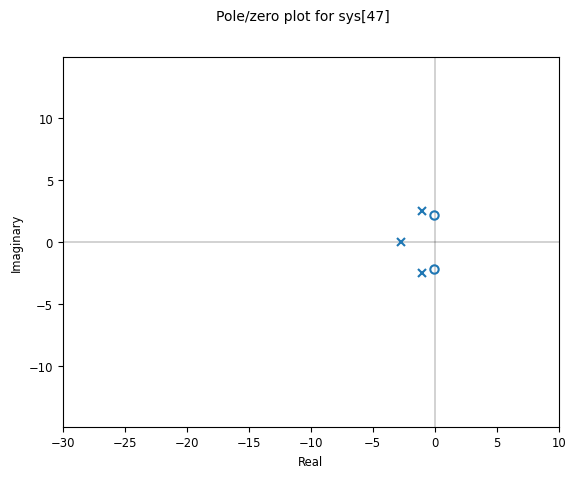

In [329]:
mod_boat_U = ct.ss(A_cn1, B, -kT, np.array([[0]]))
ct.pzmap(mod_boat_U, xlim = [-30, 10])

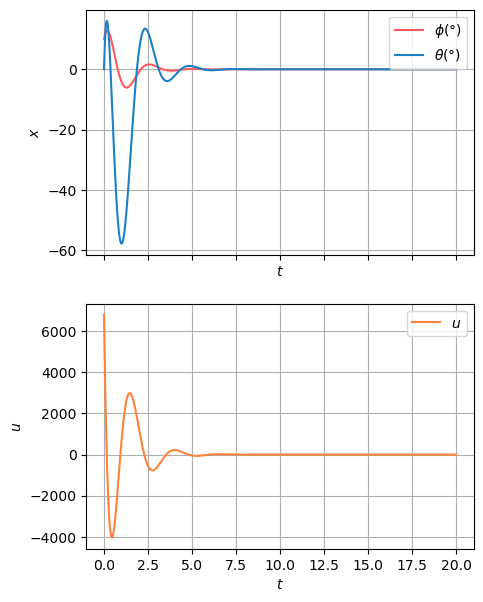

In [330]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10*np.pi/180), 0.0, 0.6, 0.0]
t, u, x = ct.forced_response(mod_boat_U, U=0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$')
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()
state.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

In [269]:
#Parâmetros para inserção de perturbações:
'''
Freqadm = np.sqrt(Bb/(2*g))
lda = g*2*np.pi/wf
k0 = 2*np.pi/lda 
aphm0 = A0/lda
'''

'\nFreqadm = np.sqrt(Bb/(2*g))\nlda = g*2*np.pi/wf\nk0 = 2*np.pi/lda \naphm0 = A0/lda\n'

In [270]:
mod_boat_E = ct.ss(A_cn1, E, C, np.array([[0],[0],[0]]))

In [271]:
'''
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_E, U = aphm0*np.sin(wf*ts), T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$')
#state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()

control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta$')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()
'''

"\nts = np.linspace(0, 20, 1001)\nw = np.linspace(0.1, 0.1, 1001)\nx0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]\nt, y, x = ct.forced_response(mod_boat_E, U = aphm0*np.sin(wf*ts), T=ts, X0=x0, return_x=True)\n\nfig, (state, control_input) = plt.subplots(\n    2, 1, figsize=(5, 7), sharex=True)\n\nstate.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\\phi (°)$')\n#state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')\n#state.plot(t, x[2, :], color=cp['red'], label=r'$\\dot\\phi$')\n#state.plot(t, x[3, :], color=cp['red'], label=r'$\\dot\theta$')\n# state.plot(t, x[:, 2], color='black', label=r'$x_3$')\nstate.set_ylabel(r'$x$')\nstate.set_xlabel(r'$t$')\nstate.legend()\n\ncontrol_input.plot(t, y[2,:], color=cp['orange'], label=r'$\\dot \theta$')\ncontrol_input.set_ylabel(r'$y$')\ncontrol_input.set_xlabel(r'$t$')\ncontrol_input.legend()\n"

In [272]:
mod_boat_passive = ct.ss(An(8000*np.pi/30),E,C,D)

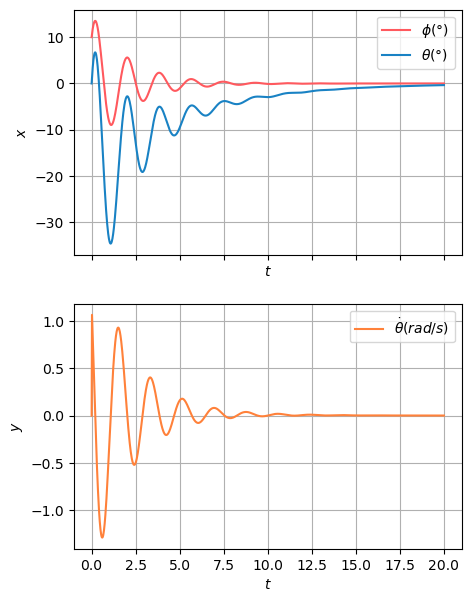

In [273]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0]
t, y, x = ct.forced_response(mod_boat_passive, U = 0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$',)
#state.plot(t, x[2, :], color=cp['blue'], label=r'$\dot \phi (rad/s)$')

state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()
state.grid()


control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta (rad/s) $')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

In [274]:
mod_boat_OFF = ct.ss(An(0*np.pi/30),E,C,D)

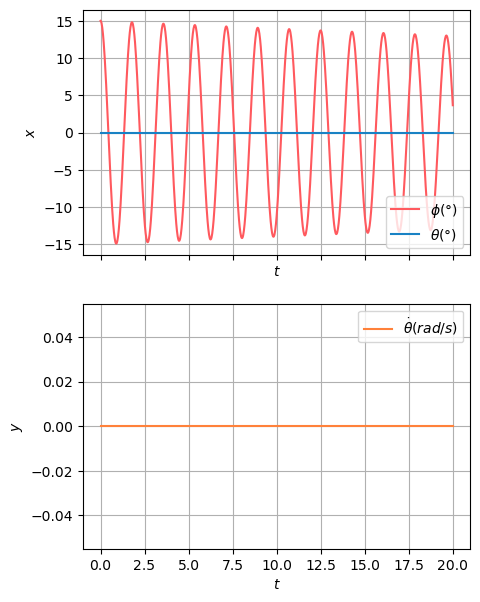

In [275]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_OFF, U = 0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()
state.grid()

control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta (rad/s) $')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Síntese do Regulador LQR

In [276]:
#Síntese do LQR:
Q = 1000*np.diag([50000, 10, 1000, 1])
R = 1

# Matriz de ganhos de controle
K_lq, P_lq, poles_lq = ct.lqr(mod_boat1, Q, R)
K_lq

# Polos do sistema em malha fechada
poles_lq


array([-9.51004333e+02+0.j        , -5.28181145e-01+3.46528888j,
       -5.28181145e-01-3.46528888j, -2.05914630e-01+0.j        ])

In [277]:
#MF do LQR:
boat_CLLQ_SS = ct.ss(An(8000*np.pi/30) - np.dot(B, K_lq), E, -K_lq, 0)
boat_CLLQ_SS

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 1.90689847e+02, -1.94186716e+02,  2.04603152e+03,
        -9.52252276e+02]]), array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ]]), array([[ 5.00719756e+02, -9.90195136e+00,  4.81566693e+02,
        -4.55769316e-01]]), array([[0.]]))

array([[list([<matplotlib.lines.Line2D object at 0x000001A19A1BCE50>]),
        list([<matplotlib.lines.Line2D object at 0x000001A19D2878D0>])]],
      dtype=object)

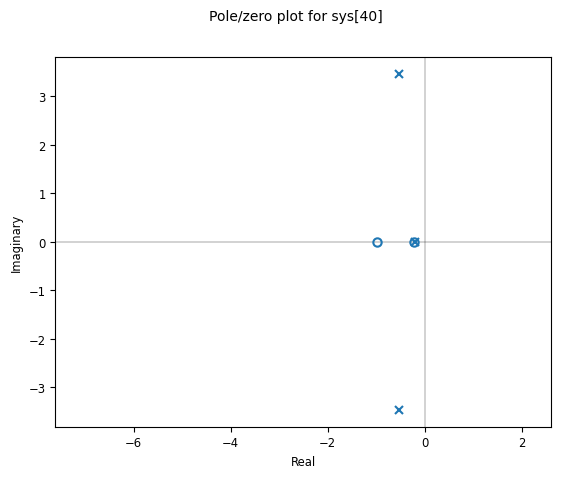

In [278]:
ct.pzmap(boat_CLLQ_SS, xlim = [-5,0])

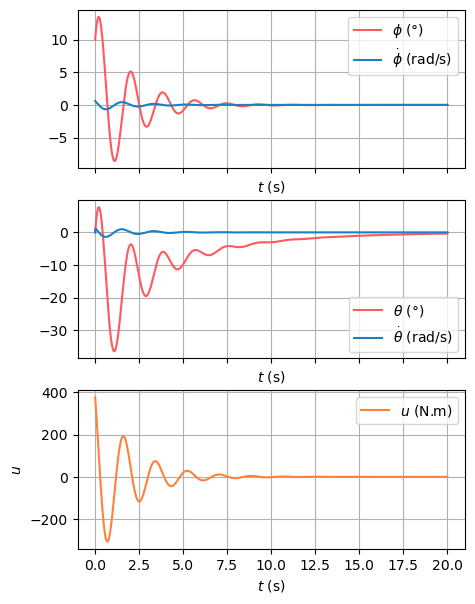

In [279]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0]
t, u, x = ct.forced_response(boat_CLLQ_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (state_roll, state_nut, control_input) = plt.subplots(
    3, 1, figsize=(5, 7), sharex=True)

state_roll.plot(t, x[0, :]*180/np.pi, color=cp['red'], label=r'$\phi$ (°)')
state_roll.plot(t, x[2, :], color=cp['blue'], label=r'$\dot \phi$ (rad/s)')
# state_pend.set_ylabel(r'$x$')
state_roll.set_xlabel(r'$t$ (s)')
state_roll.legend()
state_roll.grid()

state_nut.plot(t, x[1, :]*180/np.pi, color=cp['red'], label=r'$\theta$ (°)')
state_nut.plot(t, x[3, :], color=cp['blue'], label=r'$\dot \theta$ (rad/s)')
# state_base.set_ylabel(r'$x$')
state_nut.set_xlabel(r'$t$ (s)')
state_nut.legend()
state_nut.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

Observador de Luenberger:

In [280]:
#Posicionaremos os polos do Observador com parte real 2x mais negativa:

obs_poles = np.array([-2*9.51004154e+02 + 0.j , -2 + 0.5j , -2 - 0.5j , -3 + 0.j])
L = ct.place(An(8000*np.pi/30).T , Cn().T, obs_poles).T

A_obs = An(8000*np.pi/30) - np.dot(L,C)

Resposta em Malha Fechada do Regulador LQR + Observador de Luenberger:

In [281]:
#Construção da Matriz estendida:
Aa = np.block([[An(8000*np.pi/30) - np.dot(Bn(),K_lq), np.dot(Bn(),K_lq)],[np.zeros((n,n)), A_obs]])
Aa

array([[0.0, 0.0, 1.0, 0.0, -0.0, 0.0, -0.0, 0.0],
       [0.0, 0.0, 0.0, 1.0, -0.0, 0.0, -0.0, 0.0],
       [-12.3909097110891, 0.0, -0.0143334662850031,
        -0.48518746255907236, -0.0, 0.0, -0.0, 0.0],
       [190.6898466352382, -194.1867158461231, 2046.0315185804839,
        -952.2522764769731, -190.6898466352382, 3.770974811531095,
        -183.39575744481002, 0.1735713040120712],
       [0.0, 0.0, 0.0, 0.0, -2.08491358352827, 0.553282685836447,
        1.00000000000000, -0.994390032280085],
       [0.0, 0.0, 0.0, 0.0, -0.251331564528866, -2.26950609657295, 0,
        0.573722467908731],
       [0.0, 0.0, 0.0, 0.0, -0.494324933254287, 0.274365989965407,
        -0.0143334662850031, -2.68770913568954],
       [0.0, 0.0, 0.0, 0.0, -1.45157728694851, 1.39288606762699,
        1862.63576113567, -1904.63955485361]], dtype=object)

In [282]:
Ba = np.block([[Bn()],[np.zeros((n,1))]])
Ba

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.38083148],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [283]:
Ea = np.block([[En()],[np.zeros((n,1))]])
Ea

array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [284]:
Ka = np.block([[K_lq, np.zeros((1,n))]])
Ka

array([[-5.00719756e+02,  9.90195136e+00, -4.81566693e+02,
         4.55769316e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [285]:
boat_LQ_OBS_SS = ct.ss(Aa, Ea, -Ka, 0)
boat_LQ_OBS_SS

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00],
       [ 1.90689847e+02, -1.94186716e+02,  2.04603152e+03,
        -9.52252276e+02, -1.90689847e+02,  3.77097481e+00,
        -1.83395757e+02,  1.73571304e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.08491358e+00,  5.53282686e-01,
         1.00000000e+00, -9.94390032e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.51331565e-01, -2.26950610e+00,
         0.00000000e+00,  5.73722468e-01],
       [ 0.00000000e+00

array([[list([<matplotlib.lines.Line2D object at 0x000001A19D0E6AD0>]),
        list([<matplotlib.lines.Line2D object at 0x000001A19BC9D710>])]],
      dtype=object)

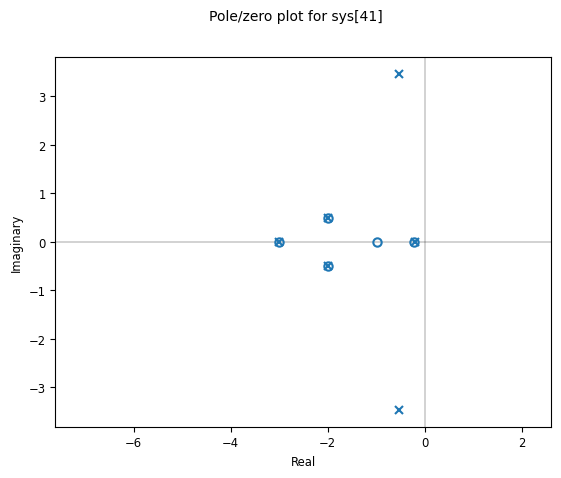

In [286]:
#Polos e Zeros:
ct.pzmap(boat_LQ_OBS_SS, xlim = [-5,0])

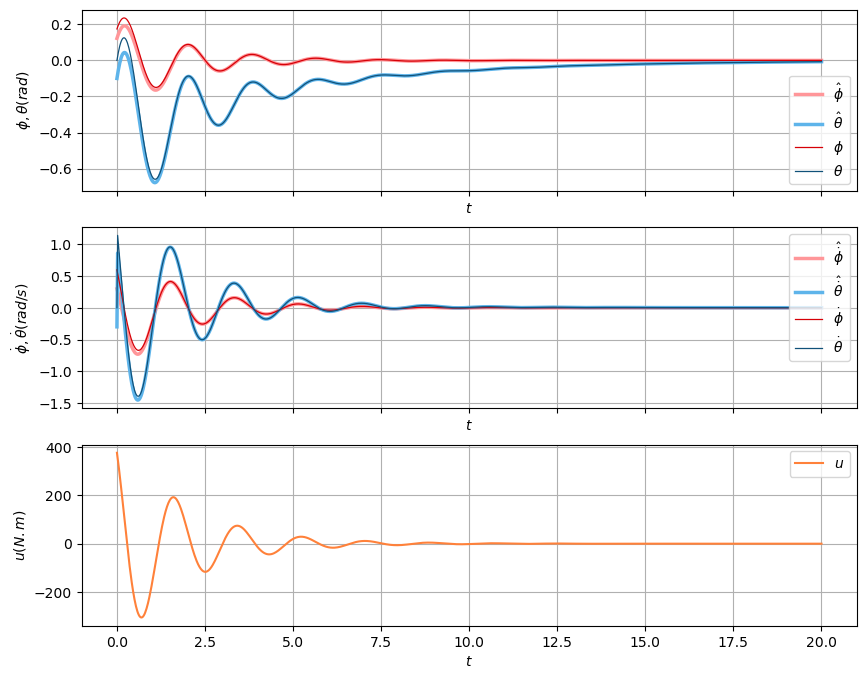

In [287]:
#Simulação Numérica:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0, (3*np.pi/180), 0.1, 0.3, 0.3]
t, u, x = ct.forced_response(boat_LQ_OBS_SS, U=0, T=ts, X0=x0, return_x=True)
xe =  x[0:4, :] - x[4:, :]

fig, (angle, vel, control_input) = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True)

angle.plot(t, xe[0, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\phi}$')
angle.plot(t, xe[1, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\theta}$')
angle.plot(t, x[0, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\phi$')
angle.plot(t, x[1, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\theta$')
angle.set_ylabel(r'$\phi, \theta (rad)$')
angle.set_xlabel(r'$t$')
angle.legend()
angle.grid()


vel.plot(t, xe[2, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\dot\phi}$')
vel.plot(t, xe[3, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\dot\theta}$')
vel.plot(t, x[2, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\dot\phi$')
vel.plot(t, x[3, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\dot\theta$')
vel.set_ylabel(r'$\dot\phi, \dot\theta (rad/s)$')
vel.set_xlabel(r'$t$')
vel.legend(loc = "upper right")
vel.grid()



control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u (N.m)$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Observador de Ordem Reduzida:

In [288]:
#Definição da Matriz T e da Matriz T^(-1)
Cro = np.array([[1,0,0,0],[0,0,0,1]])
mro = 2 #novo n° de saídas y
#V = np.eye(4)[mro:, :]
V = np.array([[0,1,0,0],[0,0,1,0]])
T = np.block([[Cro], [V]])
Ti = la.inv(T)
Ti

array([[ 1., -0.,  0.,  0.],
       [ 0., -0.,  1.,  0.],
       [ 0., -0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

In [289]:
np.linalg.matrix_rank(ct.obsv(An(8000*np.pi/30),Cro))

4

In [290]:
M = Ti[:, 0:mro]
M

array([[ 1., -0.],
       [ 0., -0.],
       [ 0., -0.],
       [ 0.,  1.]])

In [291]:
N = Ti[:, mro:]
N

array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.]])

In [292]:
#Definições das partições das matrizes A e B após transformação TAT^(-1)
A11 = Cro @ An(8000*np.pi/30) @ M
A11

array([[   0.        ,    0.        ],
       [   0.        , -952.07870517]])

In [293]:
A12 = Cro @ An(8000*np.pi/30) @ N
A12

array([[ 0.00000000e+00,  1.00000000e+00],
       [-1.90415741e+02,  1.86263576e+03]])

In [294]:
A21 = V @ An(8000*np.pi/30) @ M
A21

array([[  0.        ,   1.        ],
       [-12.39090971,  -0.48518746]])

In [295]:
A22 = V @ An(8000*np.pi/30) @ N
A22

array([[ 0.        ,  0.        ],
       [ 0.        , -0.01433347]])

In [296]:
B1 = Cro @ Bn()
B1

array([[0.        ],
       [0.38083148]])

In [297]:
B2 = V @ Bn()
B2

array([[0.],
       [0.]])

In [298]:
#Definição da Matriz J por alocação de polos:
J = (ct.place(A22.T, A12.T, [-2.0 - 1.0j, -2.0 + 1.0j])).T
J

array([[ 2.05638843e+01, -1.05033333e-02],
       [-7.79627561e+00,  5.25166667e-03]])

In [299]:
#Definição das Matrizes F, G, H e S:
F = A22 - J @ A12
G = A21  - J @ A11 + F @ J
H = B2 - J @ B1
S = M + N @ J

In [300]:
F

array([[-2., -1.],
       [ 1., -2.]])

In [301]:
#Autovalores e autovetores da Dinâmica do erro:
la.eig(F)

(array([-2.+1.j, -2.-1.j]),
 array([[2.14562269e-16+0.70710678j, 2.14562269e-16-0.70710678j],
        [7.07106781e-01+0.j        , 7.07106781e-01-0.j        ]]))

In [302]:
S

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 2.05638843e+01, -1.05033333e-02],
       [-7.79627561e+00,  5.25166667e-03],
       [ 0.00000000e+00,  1.00000000e+00]])

In [303]:
#Forma de espaço de estados em MF p/o obs de ordem reduzida:
Aa_ro = np.block([[An(8000*np.pi/30), np.zeros((n, n-mro))], 
          [G @ Cro, F]])
Aa_ro

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+02,  0.00000000e+00,  0.00000000e+00],
       [-3.33314930e+01,  0.00000000e+00,  0.00000000e+00,
        -8.98424500e+00, -2.00000000e+00, -1.00000000e+00],
       [ 2.37655258e+01,  0.00000000e+00,  0.00000000e+00,
         4.49380587e+00,  1.00000000e+00, -2.00000000e+00]])

In [304]:
Ba_ro = np.block([[B], [H]])
Ba_ro

array([[0],
       [0],
       [0],
       [0.380831482069184],
       [0.004],
       [-0.0020000000000000005]], dtype=object)

In [305]:
Ea_ro = np.block([[En()], [np.zeros((n-mro, l))]])
Ea_ro

array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [306]:
Ca_ro = np.block([[Cro, np.zeros((mro, n-mro))]])
Ca_ro

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [307]:
#Dinâmica em MF (regulador LQ + obs. de ordem reduzida):
Aa_ro_c = Aa_ro - Ba_ro @ K_lq @ np.block([S @ Cro, N])
Aa_ro_c

array([[0, 0, 1.00000000000000, 0, 0, 0],
       [0, 0, 0, 1.00000000000000, 0, 0],
       [-12.3909097110891, 0, -0.0143334662850031, -0.485187462559072, 0,
        0],
       [-1316.65991286451, -190.415741034592, 1862.63576113567,
        -951.249535285355, -3.77097481153110, 183.395757444810],
       [-47.16081090186118, 0.0, 0.0, -8.975535952280524,
        -2.0396078054371154, 0.9262667723619897],
       [30.68018475279782, 0.0, 0.0, 4.489451346914524,
        1.0198039027185577, -2.963133386180996]], dtype=object)

In [308]:
boat_CRO_U = ct.ss(Aa_ro_c, Ea_ro, -K_lq @ np.block([S @ Cro, N]), 0)
boat_CRO_X1 = ct.ss(Aa_ro_c, Ea_ro, np.array([[1, 0, 0, 0, 0, 0]]), 0)
boat_CRO_X2 = ct.ss(Aa_ro_c, Ea_ro, np.array([[0, 1, 0, 0, 0, 0]]), 0)
boat_CRO_U

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.31665991e+03, -1.90415741e+02,  1.86263576e+03,
        -9.51249535e+02, -3.77097481e+00,  1.83395757e+02],
       [-4.71608109e+01,  0.00000000e+00,  0.00000000e+00,
        -8.97553595e+00, -2.03960781e+00,  9.26266772e-01],
       [ 3.06801848e+01,  0.00000000e+00,  0.00000000e+00,
         4.48945135e+00,  1.01980390e+00, -2.96313339e+00]]), array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]]), array([[-3.45732949e+03,  0.00000000e+00,  0.00000000e+00,
         2.17726193e+00, -9.90195136e+00,  4.81566693e+02]]), array([[0.]]))

array([[list([<matplotlib.lines.Line2D object at 0x000001A1A0A973D0>]),
        list([<matplotlib.lines.Line2D object at 0x000001A19B704C10>])]],
      dtype=object)

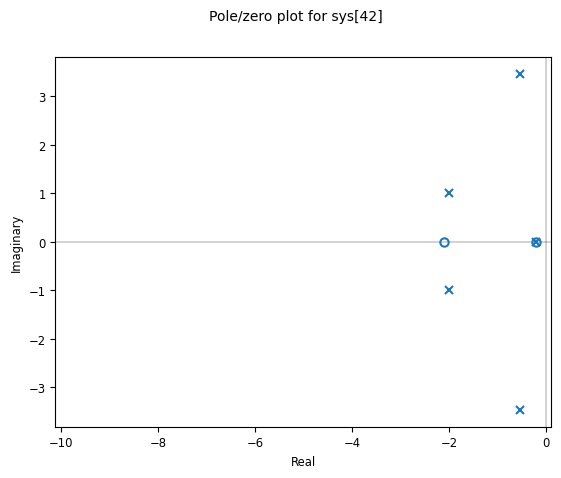

In [309]:
ct.pzmap(boat_CRO_U, xlim = [-10,0])

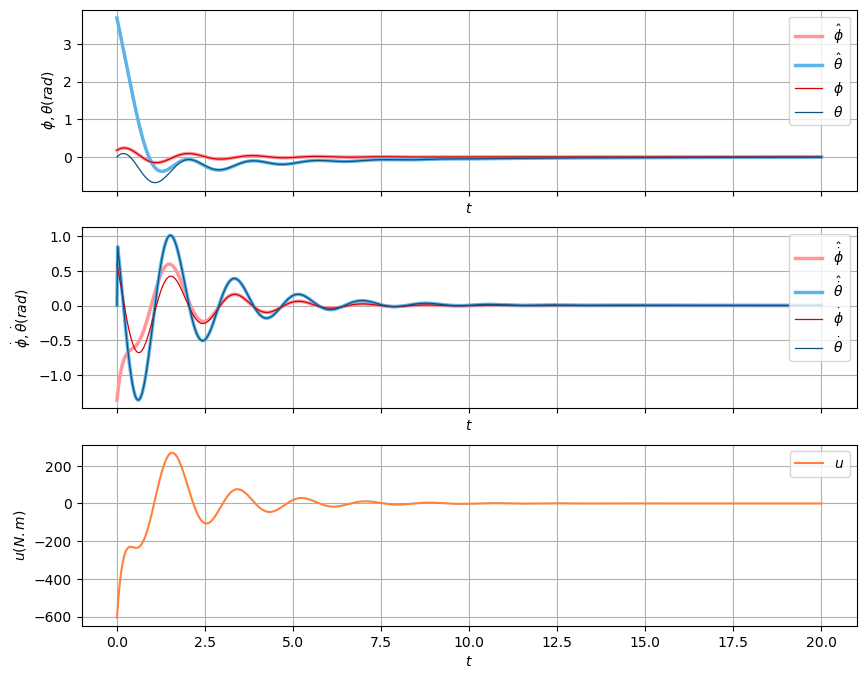

In [310]:
#Simulação Numérica:
ts = np.linspace(0, 20, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0, 0.1, 0.0]
t, u, x = ct.forced_response(boat_CRO_U, U=0, T=ts, X0=x0, return_x=True)
xe = S @ Cro @ x[0:n, :] + N @ x[n:, :]

fig, (angle, vel, control_input) = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True)

angle.plot(t, xe[0, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\phi}$')
angle.plot(t, xe[1, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\theta}$')
angle.plot(t, x[0, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\phi$')
angle.plot(t, x[1, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\theta$')
angle.set_ylabel(r'$\phi, \theta (rad)$')
angle.set_xlabel(r'$t$')
angle.legend()
angle.grid()


vel.plot(t, xe[2, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\dot\phi}$')
vel.plot(t, xe[3, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\dot\theta}$')
vel.plot(t, x[2, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\dot\phi$')
vel.plot(t, x[3, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\dot\theta$')
vel.set_ylabel(r'$\dot\phi, \dot\theta (rad)$')
vel.set_xlabel(r'$t$')
vel.legend(loc = "upper right")
vel.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u (N.m)$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Seguidor de Referência e Variáveis Exógenas:

In [311]:
#Devemos atualizar a Matriz E para ser compatível com a expressão dw(t)/dt = Aw . w(t):
Ew = np.array([[0,0],[0,0],[e_3,0],[0,0]])
Ew

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [12.39090971,  0.        ],
       [ 0.        ,  0.        ]])

In [341]:
#Matriz A_r do sinal de referência (senoidal amortecida para Phi):
ω_s = wf_base    # [rad/s]
ζ_s = 0.15     
A_r = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [-ω_s ** 2, 0, -2 * ζ_s * ω_s, 0], [0, 0, 0, 0]])

#Matriz A_w das variáveis exógenas (perturbações)
A_w = np.array([[0, wf_base],[-wf_base, 0]])

A_r


array([[ 0.       ,  0.       ,  1.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ],
       [-1.9619885,  0.       , -0.420213 ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ]])

In [342]:
#Como dispomos de apenas um atuador, escolheremos seguir a referência apenas para uma variável de estado:
M = np.array([[0,1,0,0]])

#Inversa da matriz de estados em MF
A_cl_inv = np.linalg.inv(An(8000*np.pi/30) - Bn() @ K_lq)

#Ganho de pré-alimentação
N = np.linalg.inv(M @ A_cl_inv @ Bn()) @ M @ A_cl_inv
#F = np.block([[An(8000*np.pi/30) - A_r, Ew]])
G = N @ (An(8000*np.pi/30) - A_r)
G

array([[ -421.43531023,  -500.        ,  4907.37276276, -2519.60654652]])

In [343]:
#Matrizes do sistema estendido em malha fechada:
A_ex_cl = np.block([[An(8000*np.pi/30) - Bn() @ G, Bn() @ (K_lq - G)], 
                    [A_r - An(8000*np.pi/30) + B @ G, A_r - Bn() @ (K_lq - G)]])
E_ex_cl = np.block([[Ew], [-Ew]])
#np.zeros((n,2))
K_ex = np.block([[-G, K_lq - G]])

#Forma de espaço de estados
boat_ex_cl_SS = ct.ss(A_ex_cl, E_ex_cl, K_ex, 0)
boat_ex_cl_SS

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.60495834e+02,  2.84217094e-14, -6.24628117e+00,
         7.46679017e+00, -3.01940128e+01,  1.94186716e+02,
        -2.05227780e+03,  9.59719067e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 1.04289212e+01

"\ncontrol_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')\ncontrol_input.set_xlabel(r'$t$ (s)')\ncontrol_input.legend()\ncontrol_input.grid()\n"

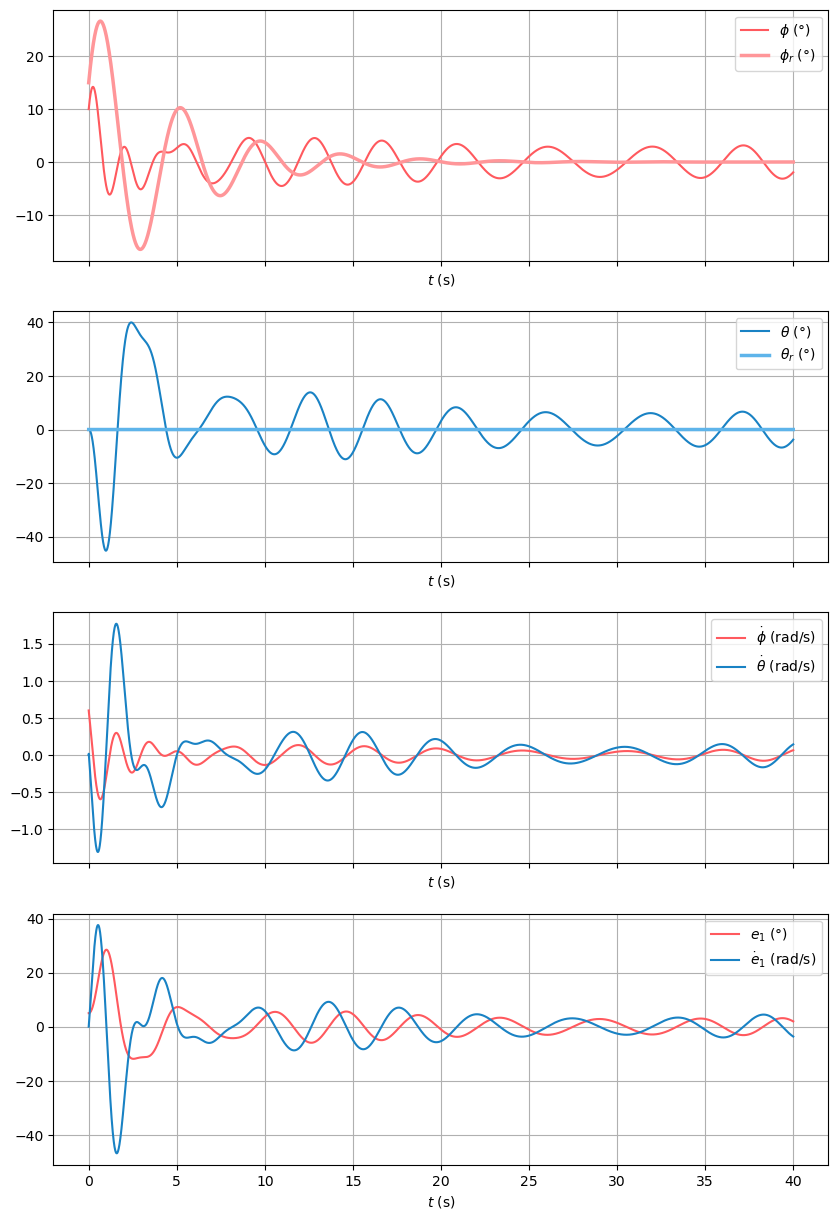

In [348]:
duration = 40 #[s]
tsteps = 20001 #n° de passos

ts = np.linspace(0, duration, tsteps)
x0 = [(10.0*np.pi/180), 0, 0.6, 0.0, 
      (5.0*np.pi/180), 0.0, 0.0, 0.0]
# x0 = [0.0, 0.3, 0.0, 0.0,
#       0.0, 0.0, 1.0, 0.0]
#aphm0*np.sin(wf*t)

#Perlin Noise functions:
noise_wf = PerlinNoise(octaves=1)
noise_A0 = PerlinNoise(octaves=2)

# Generate smooth variations in wf and A0 over time
wf_variation = np.array([wf_base + noise_wf([t / duration]) for t in ts])
A0_variation = np.array([A0_base + noise_A0([t / duration]) for t in ts])

# Interpolate the variations to match the time steps
interp_wf = interp1d(ts, wf_variation, kind='cubic')
interp_A0 = interp1d(ts, A0_variation, kind='cubic')

# Calculate wave excitation with smoothed variations
lda = g * 2 * np.pi / interp_wf(ts)
aphm0 = interp_A0(ts) / lda
Ptb = (aphm0 * np.sin(interp_wf(ts) * ts)).T
w = np.block([[Ptb],[np.zeros((1,tsteps))]])


t, u, x = ct.forced_response(boat_ex_cl_SS, U = w, T=ts, X0=x0, return_x=True)
xr = x[0:4,:] + x[4:8,:]

fig, (state_roll, state_nut, state_vel, error_x) = plt.subplots(
    4, 1, figsize=(10, 15), sharex=True)

state_roll.plot(t,(180*x[0, :]/np.pi), color=cp['red'], label=r'$\phi$ (°)')
state_roll.plot(t, (180*xr[0, :]/np.pi), linewidth=2.5, color=cp['lred'], label=r'$\phi_r$ (°)')
#state_roll.plot(t, (180*x[1, :]/np.pi), color=cp['blue'], label=r'$\theta$ (°)')
#state_roll.plot(t, (180*xr[1, :]/np.pi), linewidth=2.5, color=cp['lblue'], label=r'$\theta_r$ (°)')
state_roll.set_xlabel(r'$t$ (s)')
state_roll.legend()
state_roll.grid()

state_nut.plot(t, (180*x[1, :]/np.pi), color=cp['blue'], label=r'$\theta$ (°)')
state_nut.plot(t, (180*xr[1, :]/np.pi), linewidth=2.5, color=cp['lblue'], label=r'$\theta_r$ (°)')
state_nut.set_xlabel(r'$t$ (s)')
state_nut.legend()
state_nut.grid()



state_vel.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$ (rad/s)')
state_vel.plot(t, x[3, :], color=cp['blue'], label=r'$\dot\theta$ (rad/s)')
state_vel.set_xlabel(r'$t$ (s)')
state_vel.legend(loc = "upper right")
state_vel.grid()

error_x.plot(t, (180*x[4, :]/np.pi), color=cp['red'], label=r'$e_1$ (°)')
error_x.plot(t, (180*x[6, :]/np.pi), color=cp['blue'], label=r'$\dot e_1$ (rad/s)')
error_x.set_xlabel(r'$t$ (s)')
error_x.legend(loc = "upper right")
error_x.grid()

'''
control_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()
'''